In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from skimage.feature import hog as sk_hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import metrics
%matplotlib inline

In [2]:
""" Utility functions to display images"""
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.figure()
    plt.subplot(121), plt.imshow(a), plt.title(title1)
#     plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
#     plt.xticks([]), plt.yticks([])
    plt.grid(True)
    plt.show()  

## Extract labels from train.labels and test.labels

<class 'pandas.core.frame.DataFrame'>


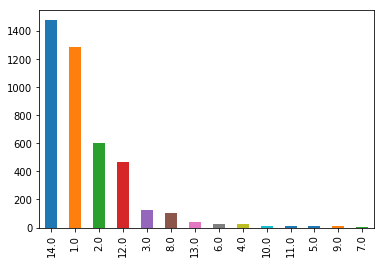

In [3]:
X_train_imgs_path = 'traffic_data/traffic-small/train'
y_train_labels_path = 'traffic_data/traffic-small/train.labels'

X_test_imgs_path = 'traffic_data/traffic-small/test'
y_test_labels_path = 'traffic_data/traffic-small/test.labels'

def read_labels(file_path):
    y_train = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.rstrip()
            y_train.append(line)
    return y_train

# y_train = read_labels(y_labels_path)
# print("first 10 labels : ", y_train[:10])
# print("total samples in training data: ", len(y_train))
# y_labels = np.array(y_train, dtype='int64')
# y_labels = pd.DataFrame(y_labels)
# y_labels[0].value_counts().plot(kind='bar')
# plt.bar(y_labels, height=10)
# plt.show()

# load data
y_train = np.loadtxt(y_train_labels_path)
y_test = np.loadtxt(y_test_labels_path)

y_labels = pd.DataFrame(y_train)
y_labels[0].value_counts().plot(kind='bar')

# y_test_labels = pd.DataFrame(y_test)
# y_test_labels[0].value_counts().plot(kind='bar')

print(type(y_labels))

## Extract images from folders, and rescale it to 64X64

In [4]:
'''function to load folder into arrays and 
then it returns that same array'''
def loadImagePaths(path):
    # Put files into lists and return them as one list
    image_files = sorted( [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.jpg')] )
    return image_files

def scale_imgs(cv2_img_list, height, width):
    dim = (width, height)
    res_img = []
    for i in range(len(cv2_img_list)):
        res = cv2.resize(cv2_img_list[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)
    return res_img


# read train images
X_train_img_paths = loadImagePaths(X_train_imgs_path)
X_train_imgs = [cv2.imread(img, cv2.IMREAD_UNCHANGED) for img in X_train_img_paths[:]]
# pre-process
X_train_imgs = scale_imgs(X_train_imgs, 64, 64)

X_train = np.array(X_train_imgs)
print(X_train.shape) # (number, M, N, Channels)

# avg_row=0
# avg_col=0
# img1 = img[0]
# print(img.shape)
# print(img1.shape)
# for i in img:
#     avg_row += int(i[0])
#     avg_col += int(i[1])
                    
# print('avg_row:', avg_row/len(img), 'avg_coln:', avg_col/len(img))

(4209, 64, 64, 3)


In [5]:
# read test dataset and convert to ndarray of pixels
X_test_img_paths = loadImagePaths(X_test_imgs_path) # load paths of all images in folder
X_test_imgs = [cv2.imread(img, cv2.IMREAD_UNCHANGED) for img in X_test_img_paths[:]] # read imgs as ndarray of pixels
X_test_imgs = scale_imgs(X_test_imgs, 64, 64) # scale imgs to 64X64
X_test = np.array(X_test_imgs) # convert list to np.ndarray
print(X_test.shape) # (number, M, N, Channels)

(4209, 64, 64, 3)


## Extract Features
### 1. HOG

In [6]:
def test_hog(img_no):
    hog_feature, hog_img = sk_hog(X_train[img_no], orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)

    display(X_train[img_no], hog_img, title2="Histogram of gradients")
    print("hog_feature vector: ", hog_feature.shape, type(hog_feature))
    print("hog_image vector: ", hog_img.shape, type(hog_img))
    
# test_hog(50)

def calc_hog(img): # hog_feature_vectors
    return sk_hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), multichannel=True)

X_train_hog = np.array( [calc_hog(img) for img in X_train] )
X_test_hog = np.array( [calc_hog(img) for img in X_test] )

print(X_train_hog.shape)
print(X_test_hog.shape)

/Users/shrey/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(4209, 512)
(4209, 512)


In [36]:
# save features
np.savetxt('train_features.txt', X_train_hog, delimiter=",")
np.savetxt('test_features.txt', X_test_hog, delimiter=",")

In [37]:
# load features
train_hog = np.loadtxt('train_features.txt', delimiter=",")
test_hog = np.loadtxt('test_features.txt', delimiter=",")

In [35]:
# chk if file exists
import os
os.path.isfile('train_features.txt')

False

## > Test hog after rescaling vs before rescaling  

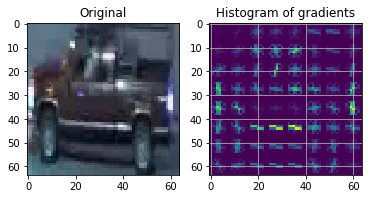

hog_feature vector:  (512,) <class 'numpy.ndarray'>
hog_image vector:  (64, 64) <class 'numpy.ndarray'>


In [7]:
test_hog(0)

(4209, 512)


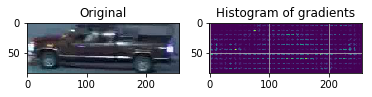

hog_feature vector:  (2560,) <class 'numpy.ndarray'>
hog_image vector:  (84, 256) <class 'numpy.ndarray'>


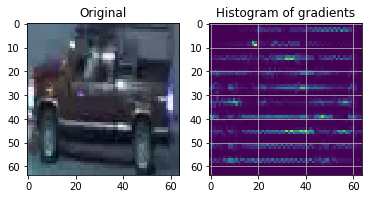

In [95]:
print(X_train_hog.shape)

# check on unprocessed image
X_img = cv2.imread(X_train_img_paths[0], cv2.IMREAD_UNCHANGED)
hog_feature, hog_img = sk_hog(X_img, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)

display(X_img, hog_img, title2="Histogram of gradients")
print("hog_feature vector: ", hog_feature.shape, type(hog_feature))
print("hog_image vector: ", hog_img.shape, type(hog_img))

#resize now
X_img = cv2.resize(X_img, (64, 64), interpolation=cv2.INTER_LINEAR)
hog_img = cv2.resize(hog_img, (64, 64), interpolation=cv2.INTER_LINEAR)
display(X_img, hog_img, title2="Histogram of gradients")

## DR

a. singular value decomposition

In [8]:
# X_train_hog 
# X_test_hog
def svd_transform(feature_dataset, components):
    svd = TruncatedSVD(n_components=components)
    svd.fit(feature_dataset)
    return svd.transform(feature_dataset)


X_train_svd = svd_transform(X_train_hog, 200)
print("X_train_svd: ", X_train_svd.shape, type(X_train_svd))

X_train_svd:  (4209, 200) <class 'numpy.ndarray'>


In [11]:
X_test_svd = svd_transform(X_test_hog, 200)
print("X_train_svd: ", X_test_svd.shape, type(X_test_svd))

X_train_svd:  (4209, 200) <class 'numpy.ndarray'>


In [12]:
np.unique(y_train)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

b. PCA

In [7]:
pca = PCA(n_components=460)
X_train_pca = pca.fit_transform(X_train_hog)
print(X_train_pca.explained_variance_ratio_) # 512 - 52=460 components seems significient 
print(X_train_pca.shape, type(X_train_pca))

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

In [65]:
pca1 = PCA(n_components=460)
X_test_pca = pca1.fit_transform(X_test_hog)
# print(X_test_pca.explained_variance_ratio_) # 512 - 52=460 components seems significient 
print(X_test_pca.shape, type(X_test_pca))

(4209, 460) <class 'numpy.ndarray'>


In [66]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn_classifier.fit(X_train_pca, y_train)

y_pred = knn_classifier.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.25      0.36      0.30      1325
         2.0       0.19      0.33      0.24       600
         3.0       0.00      0.00      0.00       139
         4.0       0.00      0.00      0.00        27
         5.0       0.00      0.00      0.00        16
         6.0       0.00      0.00      0.00        26
         7.0       0.00      0.00      0.00        12
         8.0       0.00      0.00      0.00        88
         9.0       0.00      0.00      0.00         5
        10.0       0.00      0.00      0.00        19
        11.0       0.00      0.00      0.00         5
        12.0       0.06      0.01      0.02       493
        13.0       0.00      0.00      0.00        43
        14.0       0.16      0.12      0.14      1411

   micro avg       0.20      0.20      0.20      4209
   macro avg       0.05      0.06      0.05      4209
weighted avg       0.17      0.20      0.18      4209



/Users/shrey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
print('*'*100)

****************************************************************************************************


In [7]:
one = np.arange(27).reshape((3, 3, 3))
one

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [8]:
one = one.reshape(-1)
one

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

## Apply knn model

In [9]:
# (4209, 50, 50, 3)
# X_train_inp = X_train.reshape((4209, -1)) # Raw images
# print(X_train_inp.shape)
# print(X_train_inp[0])


(4209, 7500)
[ 94 118 136 ...  66  80  98]


In [100]:
# SVD 
knn_classifier = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn_classifier.fit(X_train_svd, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [103]:
y_pred = knn_classifier.predict(X_test_svd)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.30      0.43      0.35      1325
         2.0       0.14      0.12      0.13       600
         3.0       0.05      0.01      0.02       139
         4.0       0.00      0.00      0.00        27
         5.0       0.00      0.00      0.00        16
         6.0       0.00      0.00      0.00        26
         7.0       0.00      0.00      0.00        12
         8.0       0.00      0.00      0.00        88
         9.0       0.00      0.00      0.00         5
        10.0       0.00      0.00      0.00        19
        11.0       0.00      0.00      0.00         5
        12.0       0.06      0.03      0.04       493
        13.0       0.00      0.00      0.00        43
        14.0       0.20      0.20      0.20      1411

   micro avg       0.23      0.23      0.23      4209
   macro avg       0.05      0.06      0.05      4209
weighted avg       0.19      0.23      0.20      4209



/Users/shrey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
#using hog features only (512,) dim per img
knn_classifier = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn_classifier.fit(X_train_hog, y_train)

y_pred = knn_classifier.predict(X_test_hog)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.65      0.84      0.73      1325
         2.0       0.46      0.39      0.42       600
         3.0       0.57      0.12      0.19       139
         4.0       0.43      0.11      0.18        27
         5.0       0.08      0.19      0.11        16
         6.0       1.00      0.31      0.47        26
         7.0       0.00      0.00      0.00        12
         8.0       0.36      0.09      0.15        88
         9.0       0.00      0.00      0.00         5
        10.0       0.50      0.11      0.17        19
        11.0       0.00      0.00      0.00         5
        12.0       0.88      0.71      0.79       493
        13.0       1.00      0.02      0.05        43
        14.0       0.88      0.93      0.90      1411

   micro avg       0.72      0.72      0.72      4209
   macro avg       0.49      0.27      0.30      4209
weighted avg       0.72      0.72      0.70      4209



/Users/shrey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
test = y_pred[:] == y_test[:]
df_test = pd.Series(test)
print(df_test.describe())


# for i in range(10):
#     print(y_test[i], y_pred[i], test[i])


# np.savetxt('pred_test.txt', y_pred[:10], fmt='%d', delimiter="\n")

count     4209
unique       2
top       True
freq      3043
dtype: object


In [109]:
# Raw images
X_train_inp = X_train.reshape((4209, -1)) 
X_test_inp = X_test.reshape((4209, -1))
print(X_train_inp.shape)
print(X_test_inp.shape)


knn_classifier = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn_classifier.fit(X_train_inp, y_train)

y_pred = knn_classifier.predict(X_test_inp)
print(metrics.classification_report(y_test, y_pred))

(4209, 12288)
(4209, 12288)
              precision    recall  f1-score   support

         1.0       0.62      0.77      0.69      1325
         2.0       0.44      0.15      0.23       600
         3.0       0.50      0.01      0.01       139
         4.0       1.00      0.07      0.14        27
         5.0       1.00      0.06      0.12        16
         6.0       0.48      0.46      0.47        26
         7.0       0.00      0.00      0.00        12
         8.0       0.67      0.02      0.04        88
         9.0       0.00      0.00      0.00         5
        10.0       0.00      0.00      0.00        19
        11.0       0.00      0.00      0.00         5
        12.0       0.86      0.80      0.82       493
        13.0       0.79      0.26      0.39        43
        14.0       0.74      0.98      0.84      1411

   micro avg       0.69      0.69      0.69      4209
   macro avg       0.51      0.26      0.27      4209
weighted avg       0.66      0.69      0.64      420

/Users/shrey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [112]:
# Raw images reduced dimension
X_train_inp = X_train.reshape((4209, -1)) 
X_train_inp = svd_transform(X_train_inp, 1000)
X_test_inp = X_test.reshape((4209, -1))
X_test_inp = svd_transform(X_test_inp, 1000)

print(X_train_inp.shape)
print(X_test_inp.shape)

knn_classifier = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn_classifier.fit(X_train_inp, y_train)

y_pred = knn_classifier.predict(X_test_inp)
print(metrics.classification_report(y_test, y_pred))

(4209, 1000)
(4209, 1000)
              precision    recall  f1-score   support

         1.0       0.54      0.67      0.60      1325
         2.0       0.24      0.07      0.10       600
         3.0       0.00      0.00      0.00       139
         4.0       0.00      0.00      0.00        27
         5.0       0.00      0.00      0.00        16
         6.0       0.27      0.15      0.20        26
         7.0       0.00      0.00      0.00        12
         8.0       0.43      0.03      0.06        88
         9.0       0.00      0.00      0.00         5
        10.0       0.00      0.00      0.00        19
        11.0       0.00      0.00      0.00         5
        12.0       0.71      0.60      0.65       493
        13.0       0.29      0.05      0.08        43
        14.0       0.65      0.91      0.76      1411

   micro avg       0.60      0.60      0.60      4209
   macro avg       0.22      0.18      0.17      4209
weighted avg       0.52      0.60      0.54      4209


/Users/shrey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
!which python


/Users/shrey/anaconda3/bin/python


## SVM

In [7]:
'''
def calc_hog(img): # hog_feature_vectors
    return sk_hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), multichannel=True)

X_train_hog = np.array( [calc_hog(img) for img in X_train] )
X_test_hog = np.array( [calc_hog(img) for img in X_test] )

print(X_train_hog.shape)
print(X_test_hog.shape)
'''
from sklearn import svm

svm_classifier = svm.SVC(gamma='scale', decision_function_shape='ovo')
svm_classifier.fit(X_train_hog, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
pred = svm_classifier.predict(X_test_hog)

In [9]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.58      0.95      0.72      1325
         2.0       1.00      0.01      0.03       600
         3.0       0.00      0.00      0.00       139
         4.0       0.00      0.00      0.00        27
         5.0       0.00      0.00      0.00        16
         6.0       0.00      0.00      0.00        26
         7.0       0.00      0.00      0.00        12
         8.0       0.00      0.00      0.00        88
         9.0       0.00      0.00      0.00         5
        10.0       0.00      0.00      0.00        19
        11.0       0.00      0.00      0.00         5
        12.0       0.88      0.70      0.78       493
        13.0       0.00      0.00      0.00        43
        14.0       0.81      0.95      0.87      1411

   micro avg       0.70      0.70      0.70      4209
   macro avg       0.23      0.19      0.17      4209
weighted avg       0.70      0.70      0.62      4209



/Users/shrey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
pred

array([14.,  1.,  1., ..., 12., 12., 14.])